In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os.path
from scipy.stats import friedmanchisquare

index_list = [
    "loadtest-webrtc-preliminary-mediasoup-2p-t3medium-final", "loadtest-webrtc-preliminary-mediasoup-2p-c5xlarge-final",
    "loadtest-webrtc-preliminary-mediasoup-5p-t3medium-final", "loadtest-webrtc-preliminary-mediasoup-5p-c5xlarge-final",
    "loadtest-webrtc-preliminary-mediasoup-6p-t3medium-final", "loadtest-webrtc-preliminary-mediasoup-6p-c5xlarge-final",
    "loadtest-webrtc-preliminary-mediasoup-7p-t3medium-final", "loadtest-webrtc-preliminary-mediasoup-7p-c5xlarge-final",
    "loadtest-webrtc-preliminary-mediasoup-8p-t3medium-final", "loadtest-webrtc-preliminary-mediasoup-8p-c5xlarge-final",
    "loadtest-webrtc-preliminary-mediasoup-10p-t3medium-final", "loadtest-webrtc-preliminary-mediasoup-10p-c5xlarge-final",
    "loadtest-webrtc-preliminary-mediasoup-3p-10s-t3medium-final", "loadtest-webrtc-preliminary-mediasoup-3p-10s-c5xlarge-final",
    "loadtest-webrtc-preliminary-mediasoup-3p-40s-t3medium-final", "loadtest-webrtc-preliminary-mediasoup-3p-40s-c5xlarge-final"
]

node_types = ["browseremulator", "masternode", "medianode"]

seconds_per_fragment = 17


In [2]:
df_list = [pd.read_csv(f"dfs/{x}.csv")
           for x in index_list if os.path.isfile(f"dfs/{x}.csv")]
for df_user in df_list:
    df_user["@timestamp"] = pd.to_datetime(df_user["@timestamp"])
    df_user["cut_index"] = df_user["cut_index"] * seconds_per_fragment


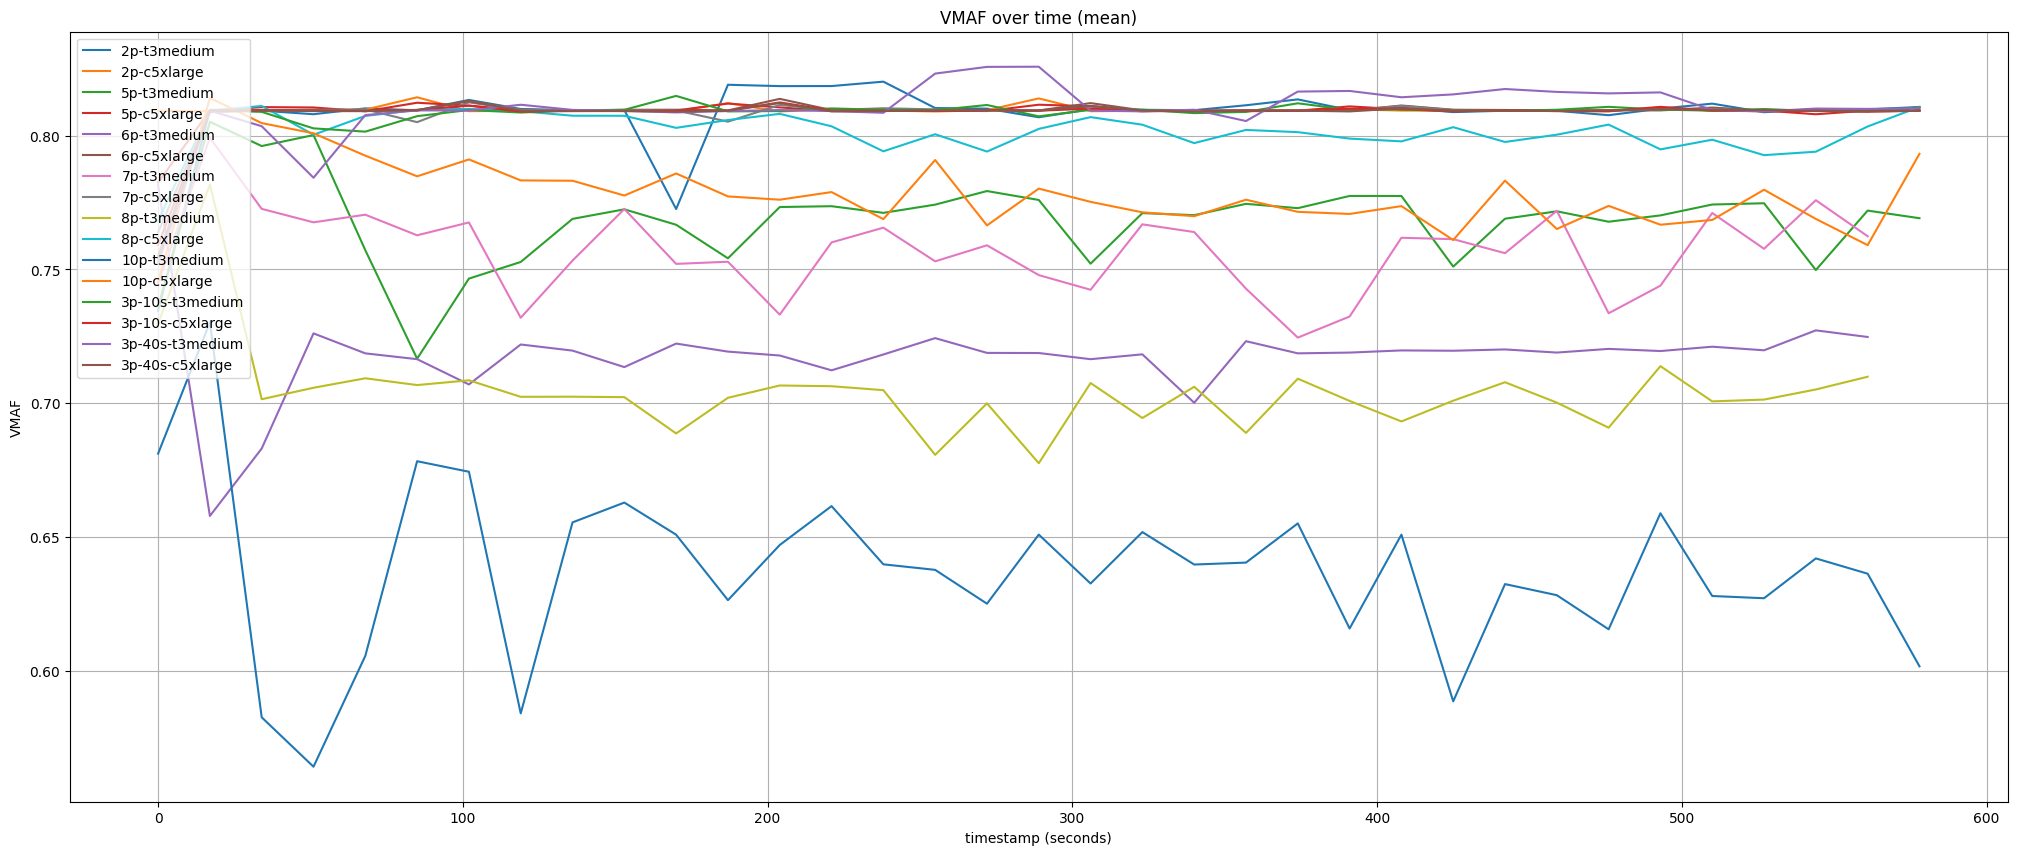

In [3]:
plt.rcParams['figure.figsize'] = [25, 10]


for i, df_tmp in enumerate(df_list):
    df_mean = df_tmp.groupby(["cut_index"]).mean(numeric_only=True)
    plot_name = index_list[i][38:-6]
    if not df_mean.empty:
        plt.plot(df_mean.index, df_mean["vmaf"], label=plot_name)

plt.title("VMAF over time (mean)")
plt.xlabel("timestamp (seconds)")
plt.ylabel("VMAF")
plt.grid()
# plt.ylim(0, 1)
plt.legend(loc="upper left")


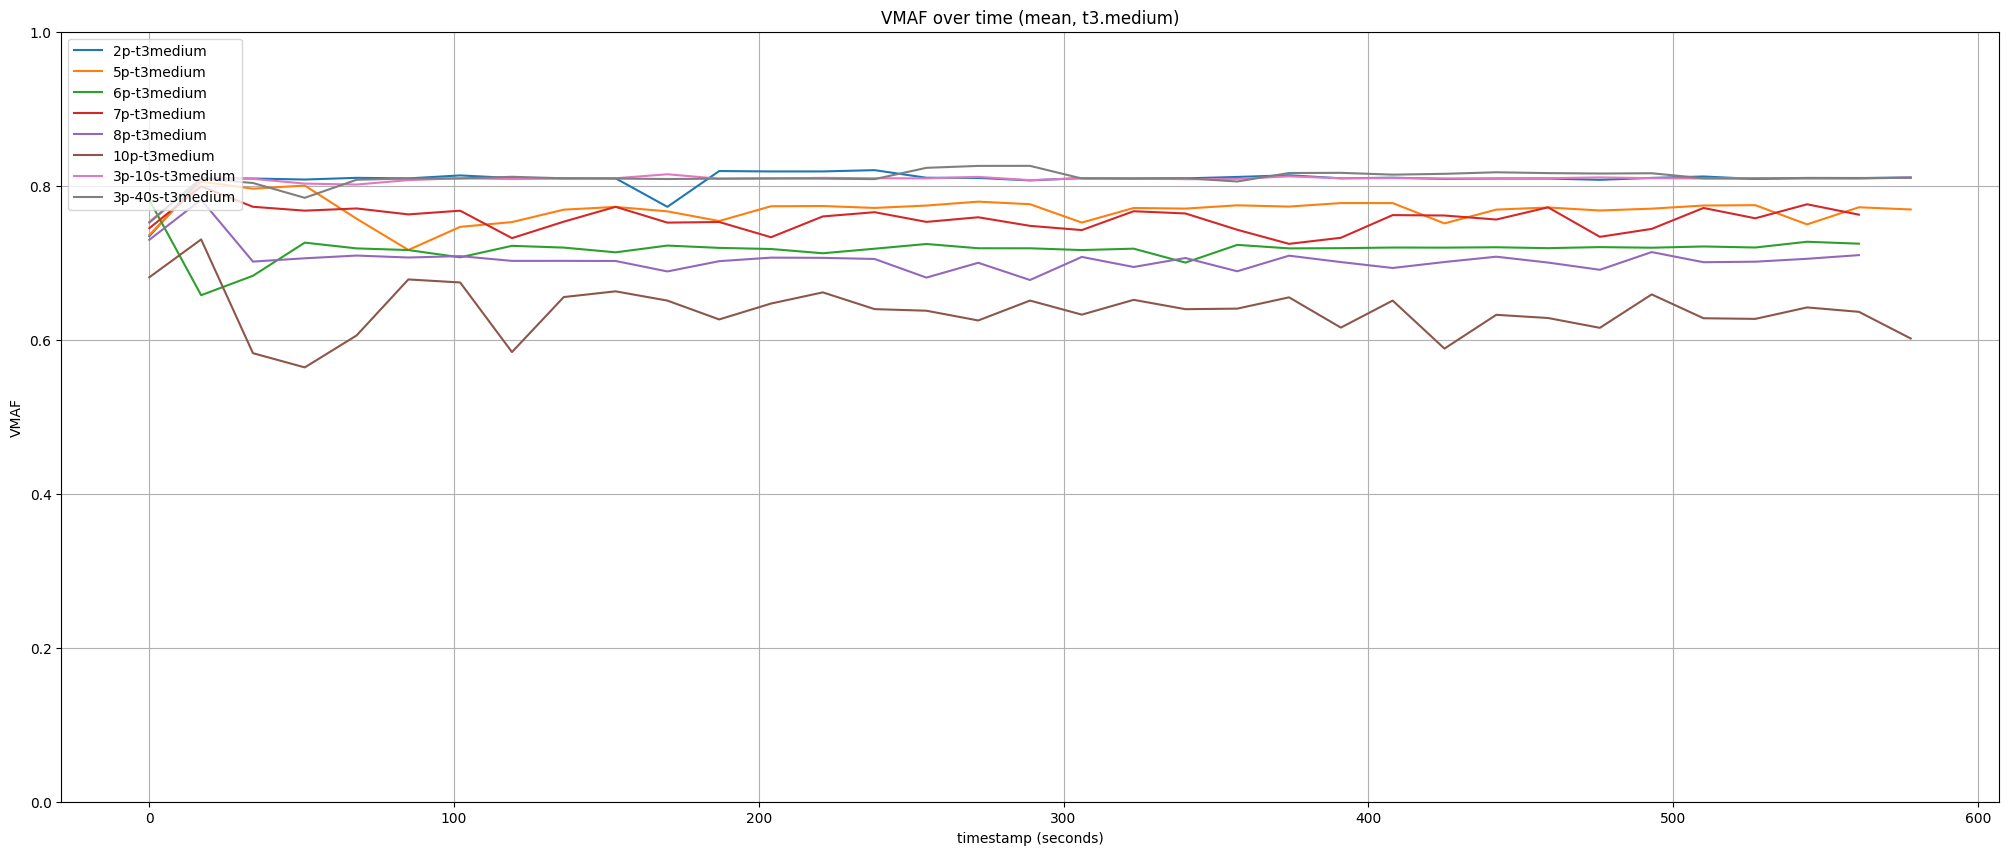

In [11]:
plt.rcParams['figure.figsize'] = [25, 10]


for i, df_tmp in enumerate(df_list):
    if (i % 2 == 0):
        df_mean = df_tmp.groupby(["cut_index"]).mean(numeric_only=True)
        plot_name = index_list[i][38:-6]
        if not df_mean.empty:
            plt.plot(df_mean.index, df_mean["vmaf"], label=plot_name)

plt.title("VMAF over time (mean, t3.medium)")
plt.xlabel("timestamp (seconds)")
plt.ylabel("VMAF")
plt.grid()
plt.ylim(0, 1)
plt.legend(loc="upper left")


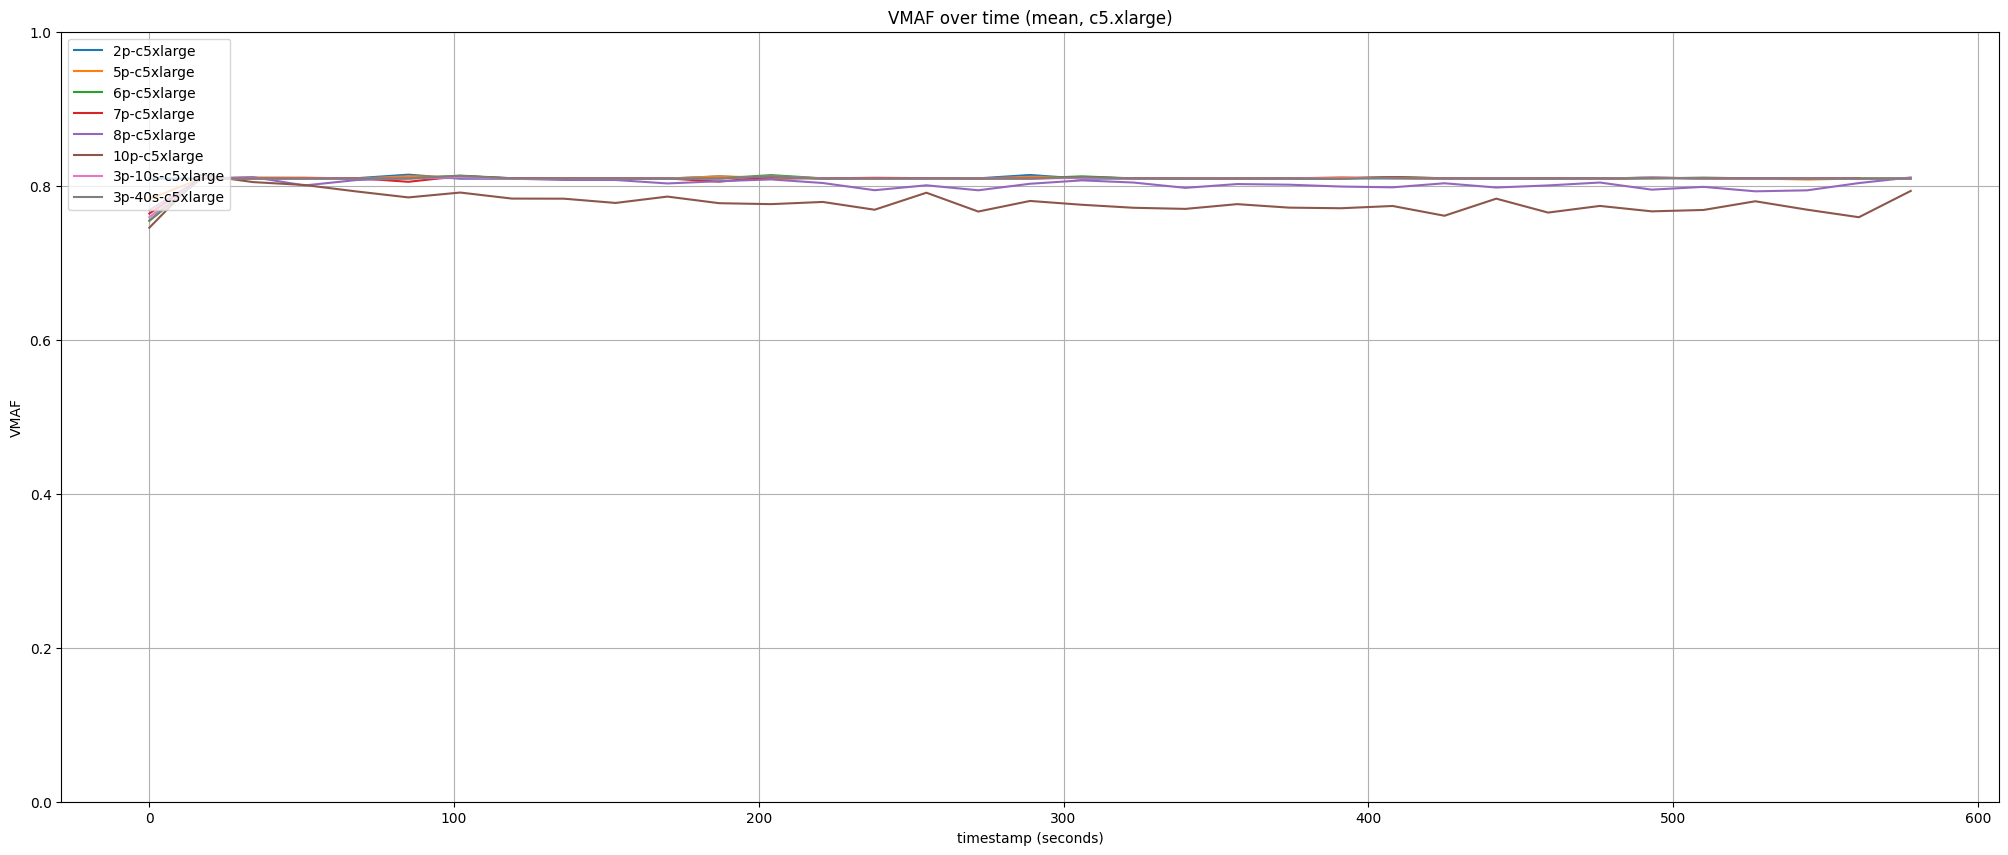

In [10]:
plt.rcParams['figure.figsize'] = [25, 10]


for i, df_tmp in enumerate(df_list):
    if (i % 2 != 0):
        df_mean = df_tmp.groupby(["cut_index"]).mean(numeric_only=True)
        plot_name = index_list[i][38:-6]
        if not df_mean.empty:
            plt.plot(df_mean.index, df_mean["vmaf"], label=plot_name)

plt.title("VMAF over time (mean, c5.xlarge)")
plt.xlabel("timestamp (seconds)")
plt.ylabel("VMAF")
plt.grid()
plt.ylim(0, 1)
plt.legend(loc="upper left")


In [6]:
# INDIVIDUAL PLOTS PARAMETERS

# Index of index_list to use
index = 11
#If there is only one metric in display, choose which one
metric = "vmaf"

show_full_range = False

# Calculations
index_name = index_list[index]
metric_label = metric.upper()
qoe_metrics_normalized = ["vmaf", "msssim", "ssim", "vifp", "pesq", "visqol"]
qoe_metrics_not_normalized = ["psnr", "psnrhvs", "psnrhvsm"]

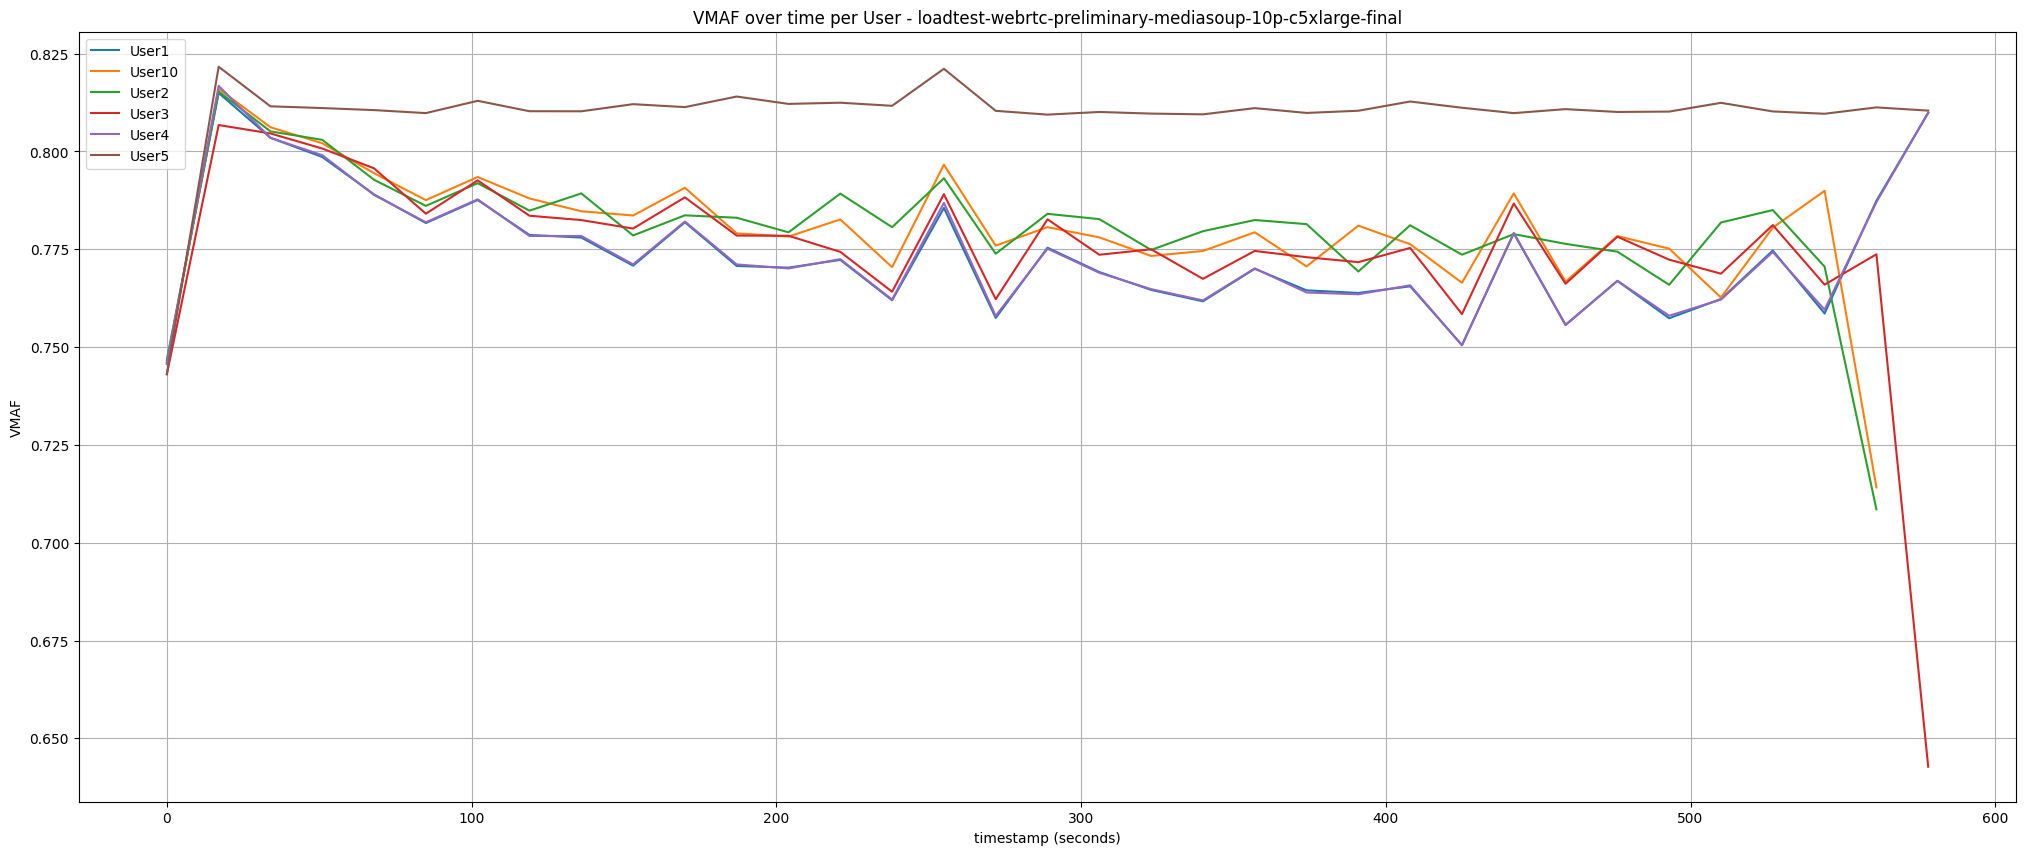

In [7]:
plt.rcParams['figure.figsize'] = [25, 10]

df_user = df_list[index]

for user in df_user.userFrom.unique():
    df_user1 = df_user[df_user.userFrom == user].groupby(["cut_index"]).mean(numeric_only=True)
    plt.plot(df_user1.index, df_user1[metric], label=user)

plt.title(metric_label + " over time per User - " + index_name)
plt.xlabel("timestamp (seconds)")
plt.ylabel(metric_label)
plt.legend(loc="upper left")
plt.grid()
if show_full_range:
    plt.ylim(0, 1)


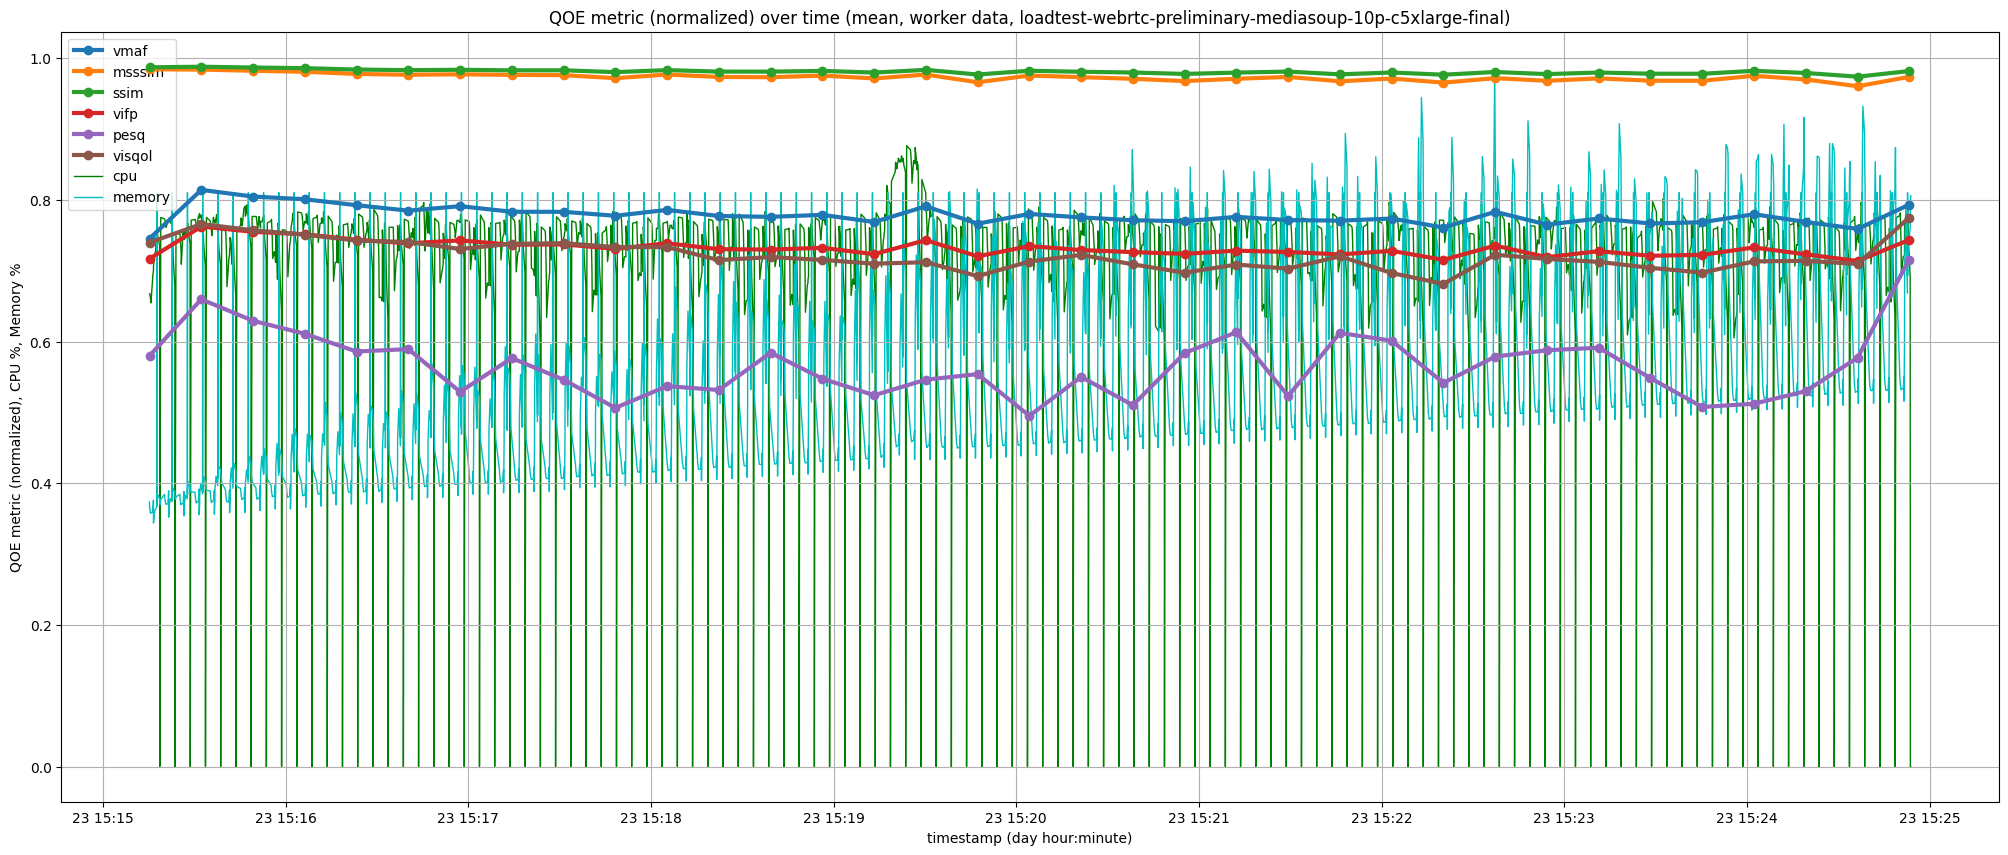

In [8]:
plt.rcParams['figure.figsize'] = [25, 10]

aggregation_map =  {"@timestamp": "first"}
for metric in qoe_metrics_normalized:
    aggregation_map[metric] = "mean"

df_tmp = df_list[index].groupby("cut_index").agg(aggregation_map)
df_node = pd.read_csv(f"dfs/{index_name}-browseremulator.csv")
df_node["@timestamp"] = pd.to_datetime(df_node["@timestamp"])
df = pd.concat([df_tmp, df_node])

qoe_zorder = 10
resource_zorder = 0

qoe_linewidth = 3
resource_linewidth = 1

for metric in qoe_metrics_normalized:
    plt.plot(df["@timestamp"], df[metric], label=metric,
             marker="o", zorder=qoe_zorder, lw=qoe_linewidth)
plt.plot(df["@timestamp"], df["cpu"].interpolate(method="linear"), "g",
         label="cpu", zorder=resource_zorder, lw=resource_linewidth)
plt.plot(df["@timestamp"], df["memory"].interpolate(method="linear"), "c",
         label="memory", zorder=resource_zorder, lw=resource_linewidth)

plt.title(f"QOE metric (normalized) over time (mean, worker data, {index_name})")
plt.xlabel("timestamp (day hour:minute)")
plt.ylabel("QOE metric (normalized), CPU %, Memory %")
plt.grid()
if show_full_range:
    plt.ylim(0, 1)
plt.legend(loc="upper left")


In [22]:
vmaf_series = []
for i, df_tmp in enumerate(df_list):
    if (i % 2 == 0):
        df_mean = df_tmp.groupby(["cut_index"]).mean(numeric_only=True)
        vmaf_series.append(df_mean["vmaf"][:34])

friedmanchisquare(*vmaf_series)

FriedmanchisquareResult(statistic=215.98039215686276, pvalue=4.703432042230085e-43)